In [21]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from geopy.distance import geodesic


df = pd.read_csv('./data/uber.csv')

print("Dataset shape (rows, columns):", df.shape)
print("\nFirst 5 rows:")
print(df.head())


print("\nData types of each column:")
print(df.dtypes)

print("\nSummary statistics for numeric variables:")
print(df.describe())

print("\nSummary statistics for categorical/object variables:")
print(df.describe(include=['object']))

print("\nMissing values per column:")
print(df.isnull().sum())

print("\nNumber of duplicate rows:")
print(df.duplicated().sum())

for col in df.select_dtypes(include=['object']).columns:
    print(f"\nUnique values in column '{col}':")
    print(df[col].value_counts().head(10))  


Dataset shape (rows, columns): (200000, 9)

First 5 rows:
   Unnamed: 0                            key  fare_amount  \
0    24238194    2015-05-07 19:52:06.0000003          7.5   
1    27835199    2009-07-17 20:04:56.0000002          7.7   
2    44984355   2009-08-24 21:45:00.00000061         12.9   
3    25894730    2009-06-26 08:22:21.0000001          5.3   
4    17610152  2014-08-28 17:47:00.000000188         16.0   

           pickup_datetime  pickup_longitude  pickup_latitude  \
0  2015-05-07 19:52:06 UTC        -73.999817        40.738354   
1  2009-07-17 20:04:56 UTC        -73.994355        40.728225   
2  2009-08-24 21:45:00 UTC        -74.005043        40.740770   
3  2009-06-26 08:22:21 UTC        -73.976124        40.790844   
4  2014-08-28 17:47:00 UTC        -73.925023        40.744085   

   dropoff_longitude  dropoff_latitude  passenger_count  
0         -73.999512         40.723217                1  
1         -73.994710         40.750325                1  
2         

In [3]:

df = df.dropna(subset=[
    'fare_amount', 
    'pickup_longitude', 'pickup_latitude',
    'dropoff_longitude', 'dropoff_latitude',
    'pickup_datetime'
])


df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'], errors='coerce')
df = df.dropna(subset=['pickup_datetime']) 

df = df[df['fare_amount'] > 0] 


if 'passenger_count' in df.columns:
    df = df[(df['passenger_count'] > 0) & (df['passenger_count'] <= 6)]

df = df.drop_duplicates()


df.to_csv('./data/uber_cleaned.csv', index=False)
print("\n Cleaned dataset exported to './data/uber_cleaned.csv'")


print("\nAfter cleaning:")
print("Shape:", df.shape)
print("Remaining missing values:")
print(df.isnull().sum())


 Cleaned dataset exported to './data/uber_cleaned.csv'

After cleaning:
Shape: (199268, 9)
Remaining missing values:
Unnamed: 0           0
key                  0
fare_amount          0
pickup_datetime      0
pickup_longitude     0
pickup_latitude      0
dropoff_longitude    0
dropoff_latitude     0
passenger_count      0
dtype: int64



 Exploratory Data Analysis

 Descriptive Statistics:
Mean fare: $ 11.37
Median fare: $ 8.5
Mode fare: $ 6.5
Standard deviation: $ 9.91

 Quartiles:
0.25     6.0
0.50     8.5
0.75    12.5
Name: fare_amount, dtype: float64

 Fare range:
Min fare: $ 0.01
Max fare: $ 499.0

 Number of outliers in fare_amount: 17121


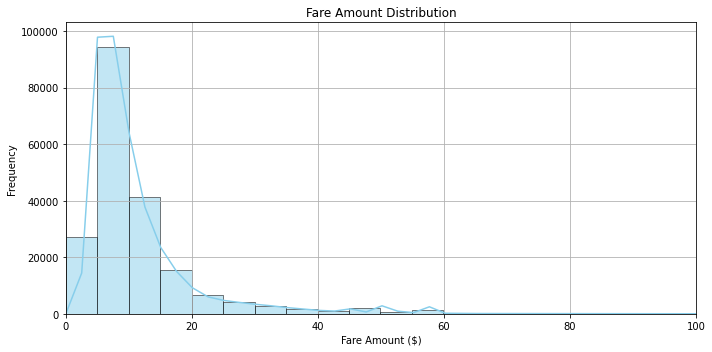

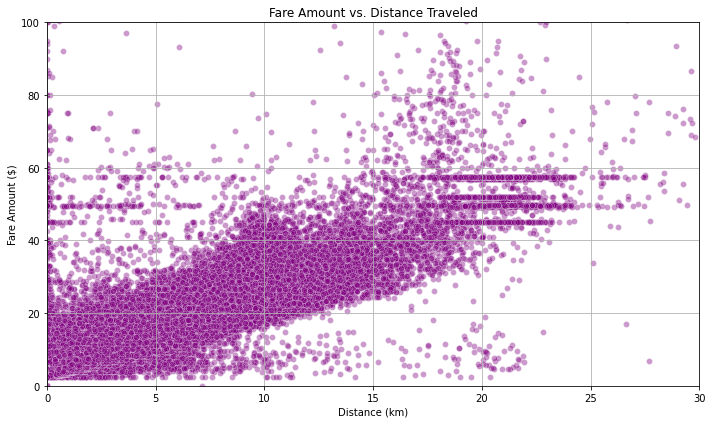

C:\Users\pc\AppData\Local\Temp\ipykernel_10772\2498651702.py:72: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='hour', y='fare_amount', data=df, palette='viridis')


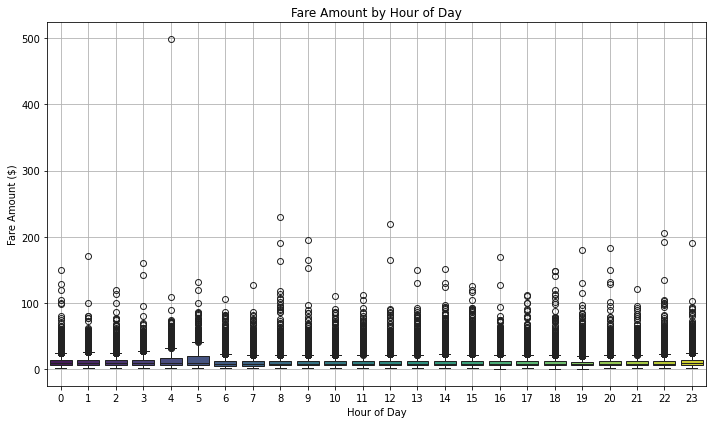

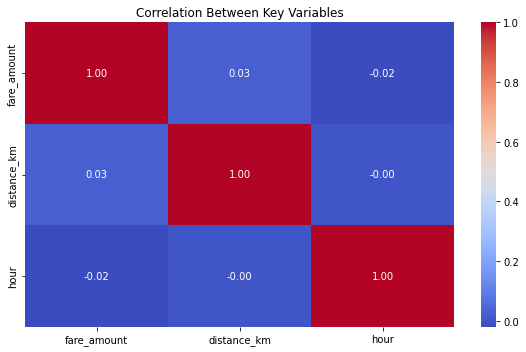

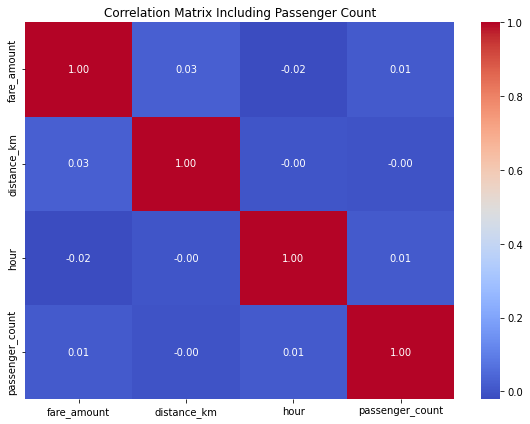

Correlation between fare amount and passenger count: 0.01


In [4]:


print("\n Exploratory Data Analysis")


print("\n Descriptive Statistics:")
print("Mean fare: $", round(df['fare_amount'].mean(), 2))
print("Median fare: $", round(df['fare_amount'].median(), 2))
print("Mode fare: $", df['fare_amount'].mode()[0])
print("Standard deviation: $", round(df['fare_amount'].std(), 2))

print("\n Quartiles:")
print(df['fare_amount'].quantile([0.25, 0.5, 0.75]))

print("\n Fare range:")
print("Min fare: $", df['fare_amount'].min())
print("Max fare: $", df['fare_amount'].max())


Q1 = df['fare_amount'].quantile(0.25)
Q3 = df['fare_amount'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers = df[(df['fare_amount'] < lower_bound) | (df['fare_amount'] > upper_bound)]
print("\n Number of outliers in fare_amount:", len(outliers))


plt.figure(figsize=(10, 5))
sns.histplot(df['fare_amount'], bins=100, kde=True, color='skyblue')
plt.title('Fare Amount Distribution')
plt.xlabel('Fare Amount ($)')
plt.ylabel('Frequency')
plt.xlim(0, 100)
plt.grid(True)
plt.tight_layout()
plt.show()


df = df[
    (df['pickup_latitude'].between(-90, 90)) &
    (df['dropoff_latitude'].between(-90, 90)) &
    (df['pickup_longitude'].between(-180, 180)) &
    (df['dropoff_longitude'].between(-180, 180))
]

from geopy.distance import geodesic

def haversine_distance(row):
    pickup = (row['pickup_latitude'], row['pickup_longitude'])
    dropoff = (row['dropoff_latitude'], row['dropoff_longitude'])
    return geodesic(pickup, dropoff).km

df['distance_km'] = df.apply(haversine_distance, axis=1)
df = df[df['distance_km'] > 0] 

df['hour'] = df['pickup_datetime'].dt.hour


plt.figure(figsize=(10, 6))
sns.scatterplot(x='distance_km', y='fare_amount', data=df, alpha=0.4, color='purple')
plt.title('Fare Amount vs. Distance Traveled')
plt.xlabel('Distance (km)')
plt.ylabel('Fare Amount ($)')
plt.xlim(0, 30)
plt.ylim(0, 100)
plt.grid(True)
plt.tight_layout()
plt.show()


plt.figure(figsize=(10, 6))
sns.boxplot(x='hour', y='fare_amount', data=df, palette='viridis')
plt.title('Fare Amount by Hour of Day')
plt.xlabel('Hour of Day')
plt.ylabel('Fare Amount ($)')
plt.grid(True)
plt.tight_layout()
plt.show()


corr = df[['fare_amount', 'distance_km', 'hour']].corr()

plt.figure(figsize=(8, 5))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Between Key Variables")
plt.tight_layout()
plt.show()


if 'passenger_count' in df.columns:
    corr_extended = df[['fare_amount', 'distance_km', 'hour', 'passenger_count']].corr()
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(corr_extended, annot=True, cmap='coolwarm', fmt=".2f")
    plt.title("Correlation Matrix Including Passenger Count")
    plt.tight_layout()
    plt.show()
    
    corr_fare_passenger = corr_extended.loc['fare_amount', 'passenger_count']
    print(f"Correlation between fare amount and passenger count: {corr_fare_passenger:.2f}")
else:
    print("Column 'passenger_count' not found in dataset.")


In [24]:
import pandas as pd
import numpy as np

# Load your dataset (change filename if needed)
df = pd.read_csv("./data/uber_cleaned.csv")

# Ensure datetime type BEFORE accessing .dt
df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'], errors='coerce')
df = df.dropna(subset=['pickup_datetime'])  # Drop rows where datetime conversion failed

# Create 'distance_km' using Haversine formula
def haversine_distance(lat1, lon1, lat2, lon2):
    R = 6371  # Radius of Earth in kilometers
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat / 2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2)**2
    c = 2 * np.arcsin(np.sqrt(a))
    return R * c

df['distance_km'] = haversine_distance(
    df['pickup_latitude'], df['pickup_longitude'],
    df['dropoff_latitude'], df['dropoff_longitude']
)

# Remove rows with missing or zero distances
df = df[df['distance_km'] > 0]

# Extract time components
df['hour'] = df['pickup_datetime'].dt.hour
df['day'] = df['pickup_datetime'].dt.day
df['month'] = df['pickup_datetime'].dt.month
df['day_of_week'] = df['pickup_datetime'].dt.dayofweek  # Monday=0, Sunday=6
df['year'] = df['pickup_datetime'].dt.year
df['day_name'] = df['pickup_datetime'].dt.day_name()

# Map day names to sortable values
day_order_map = {
    'Monday': 1,
    'Tuesday': 2,
    'Wednesday': 3,
    'Thursday': 4,
    'Friday': 5,
    'Saturday': 6,
    'Sunday': 7
}
df['day_order'] = df['day_name'].map(day_order_map)

# Assign seasons
def assign_season(month):
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    else:
        return 'Fall'
df['season'] = df['month'].apply(assign_season)

# Weekend flag
df['is_weekend'] = df['day_of_week'].apply(lambda x: 'Weekend' if x >= 5 else 'Weekday')

# Convert to categorical
df['season'] = df['season'].astype('category')
df['is_weekend'] = df['is_weekend'].astype('category')

# Estimate ride duration based on distance
df['ride_duration'] = (df['distance_km'] / 30) * 60
df = df[df['ride_duration'] > 0]
df['ride_duration'] = df['ride_duration'].round(2)

# Peak vs Off-Peak flag
def peak_offpeak(hour):
    if 7 <= hour <= 9 or 16 <= hour <= 19:
        return 'Peak'
    else:
        return 'Off-Peak'
df['peak_offpeak'] = df['hour'].apply(peak_offpeak)

# Encode additional categoricals
categorical_cols = ['peak_offpeak', 'day_name']
for col in categorical_cols:
    df[col] = df[col].astype('category')

# Save enhanced data
df.to_csv('./data/uber_enhanced.csv', index=False)
print("\n✅ Custom Metrics and Calculated Fields to './data/uber_enhanced.csv'")






✅ Custom Metrics and Calculated Fields to './data/uber_enhanced.csv'
